In [ ]:
!pip install yfinance
!pip install yahoofinancials
import math
import matplotlib
import numpy as np
import pandas as pd
import seaborn as sns
import time

from datetime import date
from matplotlib import pyplot as plt
from pylab import rcParams
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm_notebook
from xgboost import XGBRegressor

%matplotlib inline


import yfinance as yf
from yahoofinancials import YahooFinancials



In [ ]:
#### Input params ##################
stk_path = "./data/VTI.csv"
test_size = 0.2                # proportion of dataset to be used as test set
cv_size = 0.2                  # proportion of dataset to be used as cross-validation set
N = 3                         # for feature at day t, we use lags from t-1, t-2, ..., t-N as features

n_estimators = 100             # Number of boosted trees to fit. default = 100
max_depth = 3                  # Maximum tree depth for base learners. default = 3
learning_rate = 0.1            # Boosting learning rate (xgb’s “eta”). default = 0.1
min_child_weight = 1           # Minimum sum of instance weight(hessian) needed in a child. default = 1
subsample = 1                  # Subsample ratio of the training instance. default = 1
colsample_bytree = 1           # Subsample ratio of columns when constructing each tree. default = 1
colsample_bylevel = 1          # Subsample ratio of columns for each split, in each level. default = 1
gamma = 0                      # Minimum loss reduction required to make a further partition on a leaf node of the tree. default=0

model_seed = 100

fontsize = 14
ticklabelsize = 14

In [ ]:
def get_mov_avg_std(df, col, N):
    """
    Given a dataframe, get mean and std dev at timestep t using values from t-1, t-2, ..., t-N.
    Inputs
        df         : dataframe. Can be of any length.
        col        : name of the column you want to calculate mean and std dev
        N          : get mean and std dev at timestep t using values from t-1, t-2, ..., t-N
    Outputs
        df_out     : same as df but with additional column containing mean and std dev
    """
    mean_list = df[col].rolling(window = N, min_periods=1).mean() # len(mean_list) = len(df)
    std_list = df[col].rolling(window = N, min_periods=1).std()   # first value will be NaN, because normalized by N-1
    
    # Add one timestep to the predictions
    mean_list = np.concatenate((np.array([np.nan]), np.array(mean_list[:-1])))
    std_list = np.concatenate((np.array([np.nan]), np.array(std_list[:-1])))
    
    # Append mean_list to df
    df_out = df.copy()
    df_out[col + '_mean'] = mean_list
    df_out[col + '_std'] = std_list
    
    return df_out

def scale_row(row, feat_mean, feat_std):
    """
    Given a pandas series in row, scale it to have 0 mean and var 1 using feat_mean and feat_std
    Inputs
        row      : pandas series. Need to scale this.
        feat_mean: mean  
        feat_std : standard deviation
    Outputs
        row_scaled : pandas series with same length as row, but scaled
    """
    # If feat_std = 0 (this happens if adj_close doesn't change over N days), 
    # set it to a small number to avoid division by zero
    feat_std = 0.001 if feat_std == 0 else feat_std
    
    row_scaled = (row-feat_mean) / feat_std
    
    return row_scaled

def get_mape(y_true, y_pred): 
    """
    Compute mean absolute percentage error (MAPE)
    """
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def train_pred_eval_model(X_train_scaled, \
                          y_train_scaled, \
                          X_test_scaled, \
                          y_test, \
                          col_mean, \
                          col_std, \
                          seed=100, \
                          n_estimators=100, \
                          max_depth=3, \
                          learning_rate=0.1, \
                          min_child_weight=1, \
                          subsample=1, \
                          colsample_bytree=1, \
                          colsample_bylevel=1, \
                          gamma=0):
  



    model = XGBRegressor(seed=model_seed,
                         n_estimators=n_estimators,
                         max_depth=max_depth,
                         learning_rate=learning_rate,
                         min_child_weight=min_child_weight,
                         subsample=subsample,
                         colsample_bytree=colsample_bytree,
                         colsample_bylevel=colsample_bylevel,
                         gamma=gamma)
    
    # Train the model
    model.fit(X_train_scaled, y_train_scaled)
    
    # Get predicted labels and scale back to original range
    est_scaled = model.predict(X_test_scaled)
    est = est_scaled * col_std + col_mean

    # Calculate RMSE
    rmse = math.sqrt(mean_squared_error(y_test, est))
    mape = get_mape(y_test, est)
    
    return rmse, mape, est

In [ ]:
df = yf.download('BKNG', 
                      start='2012-02-10', 
                      end='2022-02-20', 
                      progress=False,
                 
)
print(df)

                   Open         High          Low        Close    Adj Close  \
Date                                                                          
2012-02-10   533.650024   546.900024   533.239990   545.039978   545.039978   
2012-02-13   549.429993   573.130005   547.099976   571.150024   571.150024   
2012-02-14   569.419983   588.559998   569.419983   576.940002   576.940002   
2012-02-15   581.020020   584.880005   568.609985   570.299988   570.299988   
2012-02-16   570.390015   574.239990   558.150024   571.320007   571.320007   
...                 ...          ...          ...          ...          ...   
2022-02-14  2521.570068  2580.850098  2514.139893  2545.659912  2545.659912   
2022-02-15  2573.479980  2659.899902  2573.479980  2635.159912  2635.159912   
2022-02-16  2633.800049  2715.659912  2632.219971  2703.260010  2703.260010   
2022-02-17  2664.810059  2676.409912  2612.139893  2623.949951  2623.949951   
2022-02-18  2625.020020  2639.000000  2582.979980  2

In [ ]:
#### Input params ##################
stk_path = "./data/VTI.csv"
test_size = 0.2                # proportion of dataset to be used as test set
cv_size = 0.2                  # proportion of dataset to be used as cross-validation set
N = 3                         # for feature at day t, we use lags from t-1, t-2, ..., t-N as features

n_estimators = 100             # Number of boosted trees to fit. default = 100
max_depth = 3                  # Maximum tree depth for base learners. default = 3
learning_rate = 0.1            # Boosting learning rate (xgb’s “eta”). default = 0.1
min_child_weight = 1           # Minimum sum of instance weight(hessian) needed in a child. default = 1
subsample = 1                  # Subsample ratio of the training instance. default = 1
colsample_bytree = 1           # Subsample ratio of columns when constructing each tree. default = 1
colsample_bylevel = 1          # Subsample ratio of columns for each split, in each level. default = 1
gamma = 0                      # Minimum loss reduction required to make a further partition on a leaf node of the tree. default=0

model_seed = 100

fontsize = 14
ticklabelsize = 14

In [ ]:
# Get difference between high and low of each day
df['range_hl'] = df['high'] - df['low']
df.drop(['high', 'low'], axis=1, inplace=True)

# Get difference between open and close of each day
df['range_oc'] = df['open'] - df['close']
df.drop(['open', 'close'], axis=1, inplace=True)

df.head()

,date,adj_close,volume,month,range_hl,range_oc
0,2000-02-22,300.75,242783,2,21.000,5.625
1,2000-02-23,311.25,313117,2,18.375,-10.125
2,2000-02-24,340.50,894867,2,25.125,-1.500
3,2000-02-25,341.25,401167,2,17.250,2.625
4,2000-02-28,323.25,229117,2,24.000,21.375


In [ ]:
# Add a column 'order_day' to indicate the order of the rows by date
df['order_day'] = [x for x in list(range(len(df)))]

# merging_keys
merging_keys = ['order_day']

# List of columns that we will use to create lags
lag_cols = ['adj_close', 'range_hl', 'range_oc', 'volume']
lag_cols

['adj_close', 'range_hl', 'range_oc', 'volume']

In [ ]:
shift_range = [x+1 for x in range(N)]

for shift in tqdm_notebook(shift_range):
    train_shift = df[merging_keys + lag_cols].copy()
    
    # E.g. order_day of 0 becomes 1, for shift = 1.
    # So when this is merged with order_day of 1 in df, this will represent lag of 1.
    train_shift['order_day'] = train_shift['order_day'] + shift
    
    foo = lambda x: '{}_lag_{}'.format(x, shift) if x in lag_cols else x
    train_shift = train_shift.rename(columns=foo)

    df = pd.merge(df, train_shift, on=merging_keys, how='left') #.fillna(0)
    
del train_shift

# Remove the first N rows which contain NaNs
df = df[N:]
    
df.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  This is separate from the ipykernel package so we can avoid doing imports until


  0%|          | 0/3 [00:00<?, ?it/s]

,date,adj_close,volume,month,range_hl,range_oc,order_day,adj_close_lag_1,range_hl_lag_1,range_oc_lag_1,volume_lag_1,adj_close_lag_2,range_hl_lag_2,range_oc_lag_2,volume_lag_2,adj_close_lag_3,range_hl_lag_3,range_oc_lag_3,volume_lag_3
3,2000-02-25,341.250,401167,2,17.25,2.625,3,340.500,25.125,-1.500,894867.0,311.250,18.375,-10.125,313117.0,300.75,21.000,5.625,242783.0
4,2000-02-28,323.250,229117,2,24.00,21.375,4,341.250,17.250,2.625,401167.0,340.500,25.125,-1.500,894867.0,311.25,18.375,-10.125,313117.0
5,2000-02-29,335.625,465383,2,30.00,-10.875,5,323.250,24.000,21.375,229117.0,341.250,17.250,2.625,401167.0,340.50,25.125,-1.500,894867.0
6,2000-03-01,386.250,2040883,3,34.50,-31.500,6,335.625,30.000,-10.875,465383.0,323.250,24.000,21.375,229117.0,341.25,17.250,2.625,401167.0
7,2000-03-02,429.000,1558650,3,37.50,-36.000,7,386.250,34.500,-31.500,2040883.0,335.625,30.000,-10.875,465383.0,323.25,24.000,21.375,229117.0


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5575 entries, 3 to 5577
Data columns (total 19 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   date             5575 non-null   datetime64[ns]
 1   adj_close        5575 non-null   float64       
 2   volume           5575 non-null   int64         
 3   month            5575 non-null   int64         
 4   range_hl         5575 non-null   float64       
 5   range_oc         5575 non-null   float64       
 6   order_day        5575 non-null   int64         
 7   adj_close_lag_1  5575 non-null   float64       
 8   range_hl_lag_1   5575 non-null   float64       
 9   range_oc_lag_1   5575 non-null   float64       
 10  volume_lag_1     5575 non-null   float64       
 11  adj_close_lag_2  5575 non-null   float64       
 12  range_hl_lag_2   5575 non-null   float64       
 13  range_oc_lag_2   5575 non-null   float64       
 14  volume_lag_2     5575 non-null   float64

In [ ]:
cols_list = [
"adj_close",
"range_hl",
"range_oc",
"volume"
]

for col in cols_list:
    df = get_mov_avg_std(df, col, N)
df.head()

,date,adj_close,volume,month,range_hl,range_oc,order_day,adj_close_lag_1,range_hl_lag_1,range_oc_lag_1,...,range_oc_lag_3,volume_lag_3,adj_close_mean,adj_close_std,range_hl_mean,range_hl_std,range_oc_mean,range_oc_std,volume_mean,volume_std
3,2000-02-25,341.250,401167,2,17.25,2.625,3,340.500,25.125,-1.500,...,5.625,242783.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2000-02-28,323.250,229117,2,24.00,21.375,4,341.250,17.250,2.625,...,-10.125,313117.0,341.250,NaN,17.250,NaN,2.625,NaN,401167.000000,NaN
5,2000-02-29,335.625,465383,2,30.00,-10.875,5,323.250,24.000,21.375,...,-1.500,894867.0,332.250,12.727922,20.625,4.772971,12.000,13.258252,315142.000000,121657.721703
6,2000-03-01,386.250,2040883,3,34.50,-31.500,6,335.625,30.000,-10.875,...,2.625,401167.0,333.375,9.208522,23.750,6.378675,4.375,16.196064,365222.333333,122165.543364
7,2000-03-02,429.000,1558650,3,37.50,-36.000,7,386.250,34.500,-31.500,...,21.375,229117.0,348.375,33.379213,29.500,5.267827,-7.000,26.649636,911794.333333,984929.600827


In [ ]:
# Get sizes of each of the datasets
num_cv = int(cv_size*len(df))
num_test = int(test_size*len(df))
num_train = len(df) - num_cv - num_test
print("num_train = " + str(num_train))
print("num_cv = " + str(num_cv))
print("num_test = " + str(num_test))

# Split into train, cv, and test
train = df[:num_train]
cv = df[num_train:num_train+num_cv]
train_cv = df[:num_train+num_cv]
test = df[num_train+num_cv:]
print("train.shape = " + str(train.shape))
print("cv.shape = " + str(cv.shape))
print("train_cv.shape = " + str(train_cv.shape))
print("test.shape = " + str(test.shape))

num_train = 3345
num_cv = 1115
num_test = 1115
train.shape = (3345, 27)
cv.shape = (1115, 27)
train_cv.shape = (4460, 27)
test.shape = (1115, 27)


In [ ]:
cols_to_scale = [
"adj_close"
]

for i in range(1,N+1):
    cols_to_scale.append("adj_close_lag_"+str(i))
    cols_to_scale.append("range_hl_lag_"+str(i))
    cols_to_scale.append("range_oc_lag_"+str(i))
    cols_to_scale.append("volume_lag_"+str(i))

# Do scaling for train set
# Here we only scale the train dataset, and not the entire dataset to prevent information leak
scaler = StandardScaler()
train_scaled = scaler.fit_transform(train[cols_to_scale])
print("scaler.mean_ = " + str(scaler.mean_))
print("scaler.var_ = " + str(scaler.var_))
print("train_scaled.shape = " + str(train_scaled.shape))

# Convert the numpy array back into pandas dataframe
train_scaled = pd.DataFrame(train_scaled, columns=cols_to_scale)
train_scaled[['date', 'month']] = train.reset_index()[['date', 'month']]
print("train_scaled.shape = " + str(train_scaled.shape))
train_scaled.head()

scaler.mean_ = [1.76124918e+02 1.75983118e+02 6.17242247e+00 7.17329599e-02
 9.54686336e+05 1.75834643e+02 6.17226252e+00 6.46462765e-02
 9.54606341e+05 1.75681378e+02 6.17485147e+00 6.57598717e-02
 9.54514138e+05]
scaler.var_ = [4.83938041e+04 4.82799089e+04 7.57069510e+01 4.19998629e+01
 8.46114855e+11 4.81659790e+04 7.57029618e+01 4.19763452e+01
 8.46196088e+11 4.80490912e+04 7.57573112e+01 4.19845798e+01
 8.46298907e+11]
train_scaled.shape = (3345, 13)
train_scaled.shape = (3345, 15)


,adj_close,adj_close_lag_1,range_hl_lag_1,range_oc_lag_1,volume_lag_1,adj_close_lag_2,range_hl_lag_2,range_oc_lag_2,volume_lag_2,adj_close_lag_3,range_hl_lag_3,range_oc_lag_3,volume_lag_3,date,month
0,0.750617,0.748733,2.178213,-0.242524,-0.065032,0.617018,1.402493,-1.572740,-0.697355,0.570566,1.703283,0.857967,-0.773667,2000-02-25,2
1,0.668793,0.752147,1.273142,0.393978,-0.601753,0.750295,2.178289,-0.241498,-0.064942,0.618467,1.401693,-1.572757,-0.697212,2000-02-28,2
2,0.725047,0.670227,2.048917,3.287171,-0.788795,0.753712,1.273194,0.395182,-0.601637,0.751906,2.177210,-0.241646,-0.064838,2000-02-29,2
3,0.955175,0.726547,2.738495,-1.689120,-0.531941,0.671696,2.048990,3.289185,-0.788670,0.755328,1.272440,0.394972,-0.601500,2000-03-01,3
4,1.149506,0.956946,3.255679,-4.871632,1.180847,0.728082,2.738586,-1.688500,-0.531829,0.673211,2.047957,3.288691,-0.788522,2000-03-02,3


In [ ]:
# Do scaling for train+dev set
scaler_train_cv = StandardScaler()
train_cv_scaled = scaler_train_cv.fit_transform(train_cv[cols_to_scale])
print("scaler_train_cv.mean_ = " + str(scaler_train_cv.mean_))
print("scaler_train_cv.var_ = " + str(scaler_train_cv.var_))
print("train_cv_scaled.shape = " + str(train_cv_scaled.shape))

# Convert the numpy array back into pandas dataframe
train_cv_scaled = pd.DataFrame(train_cv_scaled, columns=cols_to_scale)
train_cv_scaled[['date', 'month']] = train_cv.reset_index()[['date', 'month']]
print("train_cv_scaled.shape = " + str(train_cv_scaled.shape))
train_cv_scaled.head()

scaler_train_cv.mean_ = [4.65250451e+02 4.64941258e+02 1.06277712e+01 3.62144276e-02
 8.75232330e+05 4.64624913e+02 1.06231311e+01 4.15115128e-02
 8.75188904e+05 4.64311796e+02 1.06218239e+01 4.21561316e-02
 8.75080671e+05]
scaler_train_cv.var_ = [3.06045775e+05 3.05696447e+05 1.53336351e+02 9.55359898e+01
 6.87310390e+11 3.05347254e+05 1.53168406e+02 9.53031685e+01
 6.87350798e+11 3.05012512e+05 1.53133655e+02 9.53085133e+01
 6.87435435e+11]
train_cv_scaled.shape = (4460, 13)
train_cv_scaled.shape = (4460, 15)


,adj_close,adj_close_lag_1,range_hl_lag_1,range_oc_lag_1,volume_lag_1,adj_close_lag_2,range_hl_lag_2,range_oc_lag_2,volume_lag_2,adj_close_lag_3,range_hl_lag_3,range_oc_lag_3,volume_lag_3,date,month
0,-0.224146,-0.225071,1.170745,-0.157170,0.023684,-0.277560,0.626357,-1.041402,-0.677958,-0.296158,0.838660,0.571860,-0.762615,2000-02-25,2
1,-0.256683,-0.223714,0.534788,0.264858,-0.571823,-0.224627,1.171762,-0.157904,0.023735,-0.277146,0.626534,-1.041439,-0.677786,2000-02-28,2
2,-0.234313,-0.256270,1.079894,2.183163,-0.779352,-0.223270,0.535456,0.264638,-0.571754,-0.224183,1.172000,-0.157966,0.023864,2000-02-29,2
3,-0.142803,-0.233888,1.564433,-1.116322,-0.494365,-0.255844,1.080861,2.185286,-0.779277,-0.222825,0.535622,0.264565,-0.571588,2000-03-01,3
4,-0.065527,-0.142325,1.927837,-3.226458,1.406022,-0.233449,1.565666,-1.118228,-0.494298,-0.255417,1.081089,2.185158,-0.779098,2000-03-02,3


In [ ]:
# Do scaling for dev set
cv_scaled = cv[['date']]
for col in tqdm_notebook(cols_list):
    feat_list = [col + '_lag_' + str(shift) for shift in range(1, N+1)]
    temp = cv.apply(lambda row: scale_row(row[feat_list], row[col+'_mean'], row[col+'_std']), axis=1)
    cv_scaled = pd.concat([cv_scaled, temp], axis=1)
    
# Now the entire dev set is scaled
cv_scaled.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  This is separate from the ipykernel package so we can avoid doing imports until


  0%|          | 0/4 [00:00<?, ?it/s]

,date,adj_close_lag_1,adj_close_lag_2,adj_close_lag_3,range_hl_lag_1,range_hl_lag_2,range_hl_lag_3,range_oc_lag_1,range_oc_lag_2,range_oc_lag_3,volume_lag_1,volume_lag_2,volume_lag_3
3348,2013-06-14,0.758013,-1.133369,0.375356,-0.569379,1.154664,-0.585285,-0.994294,1.005610,-0.011316,-1.122235,0.796579,0.325656
3349,2013-06-17,0.682363,0.465531,-1.147894,-0.966866,-0.063263,1.030130,-0.294394,-0.819757,1.114151,0.514426,-1.152492,0.638066
3350,2013-06-18,1.151156,-0.497282,-0.653874,0.591661,-1.154581,0.562921,0.520672,0.632230,-1.152903,1.100833,-0.248546,-0.852287
3351,2013-06-19,0.990968,0.017825,-1.008793,0.642870,0.509250,-1.152121,-1.143390,0.432069,0.711320,-0.323208,1.121631,-0.798423
3352,2013-06-20,-0.229522,1.094807,-0.865285,-0.954725,1.039835,-0.085109,1.134649,-0.752873,-0.381776,-0.743304,-0.393609,1.136913


In [ ]:
# Do scaling for test set
test_scaled = test[['date']]
for col in tqdm_notebook(cols_list):
    feat_list = [col + '_lag_' + str(shift) for shift in range(1, N+1)]
    temp = test.apply(lambda row: scale_row(row[feat_list], row[col+'_mean'], row[col+'_std']), axis=1)
    test_scaled = pd.concat([test_scaled, temp], axis=1)
    
# Now the entire test set is scaled
test_scaled.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  This is separate from the ipykernel package so we can avoid doing imports until


  0%|          | 0/4 [00:00<?, ?it/s]

,date,adj_close_lag_1,adj_close_lag_2,adj_close_lag_3,range_hl_lag_1,range_hl_lag_2,range_hl_lag_3,range_oc_lag_1,range_oc_lag_2,range_oc_lag_3,volume_lag_1,volume_lag_2,volume_lag_3
4463,2017-11-15,0.477744,0.671524,-1.149268,-0.935939,1.053643,-0.117704,0.216027,-1.090357,0.874330,-0.498951,-0.652348,1.151299
4464,2017-11-16,1.077456,-0.898334,-0.179121,-0.290201,-0.822803,1.113004,0.520543,0.632352,-1.152895,0.577350,0.577350,-1.154701
4465,2017-11-17,0.927817,0.131379,-1.059196,-0.927500,1.059408,-0.131908,1.149722,-0.667621,-0.482101,-1.154701,0.577350,0.577350
4466,2017-11-20,1.124268,-0.334064,-0.790204,0.397585,-1.137645,0.740060,-0.809112,1.118001,-0.308889,-1.141492,0.419927,0.721565
4467,2017-11-21,0.847873,0.254911,-1.102784,0.821584,0.291882,-1.113465,0.204566,-1.086465,0.881899,0.000000,-1.000000,1.000000


In [ ]:
features = []
for i in range(1,N+1):
    features.append("adj_close_lag_"+str(i))
    features.append("range_hl_lag_"+str(i))
    features.append("range_oc_lag_"+str(i))
    features.append("volume_lag_"+str(i))

target = "adj_close"


# Split into X and y
X_train = train[features]
y_train = train[target]
X_cv = cv[features]
y_cv = cv[target]
X_train_cv = train_cv[features]
y_train_cv = train_cv[target]
X_sample = test[features]
y_sample = test[target]
print("X_train.shape = " + str(X_train.shape))
print("y_train.shape = " + str(y_train.shape))
print("X_cv.shape = " + str(X_cv.shape))
print("y_cv.shape = " + str(y_cv.shape))
print("X_train_cv.shape = " + str(X_train_cv.shape))
print("y_train_cv.shape = " + str(y_train_cv.shape))
print("X_sample.shape = " + str(X_sample.shape))
print("y_sample.shape = " + str(y_sample.shape))

X_train.shape = (3345, 12)
y_train.shape = (3345,)
X_cv.shape = (1115, 12)
y_cv.shape = (1115,)
X_train_cv.shape = (4460, 12)
y_train_cv.shape = (4460,)
X_sample.shape = (1115, 12)
y_sample.shape = (1115,)


In [ ]:
# Split into X and y
X_train_scaled = train_scaled[features]
y_train_scaled = train_scaled[target]
X_cv_scaled = cv_scaled[features]
X_train_cv_scaled = train_cv_scaled[features]
y_train_cv_scaled = train_cv_scaled[target]
X_sample_scaled = test_scaled[features]
print("X_train_scaled.shape = " + str(X_train_scaled.shape))
print("y_train_scaled.shape = " + str(y_train_scaled.shape))
print("X_cv_scaled.shape = " + str(X_cv_scaled.shape))
print("X_train_cv_scaled.shape = " + str(X_train_cv_scaled.shape))
print("y_train_cv_scaled.shape = " + str(y_train_cv_scaled.shape))
print("X_sample_scaled.shape = " + str(X_sample_scaled.shape))

X_train_scaled.shape = (3345, 12)
y_train_scaled.shape = (3345,)
X_cv_scaled.shape = (1115, 12)
X_train_cv_scaled.shape = (4460, 12)
y_train_cv_scaled.shape = (4460,)
X_sample_scaled.shape = (1115, 12)


Text(0.5, 1.0, 'Without scaling')

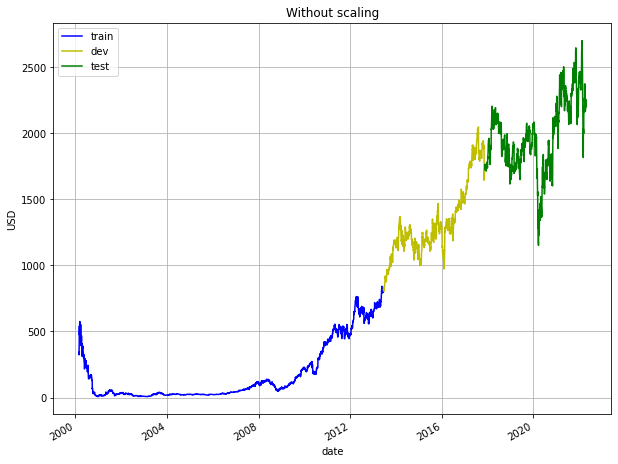

In [ ]:
rcParams['figure.figsize'] = 10, 8 # width 10, height 8

ax = train.plot(x='date', y='adj_close', style='b-', grid=True)
ax = cv.plot(x='date', y='adj_close', style='y-', grid=True, ax=ax)
ax = test.plot(x='date', y='adj_close', style='g-', grid=True, ax=ax)
ax.legend(['train', 'dev', 'test'])
ax.set_xlabel("date")
ax.set_ylabel("USD")
ax.set_title("Without scaling")

Text(0.5, 1.0, 'With scaling')

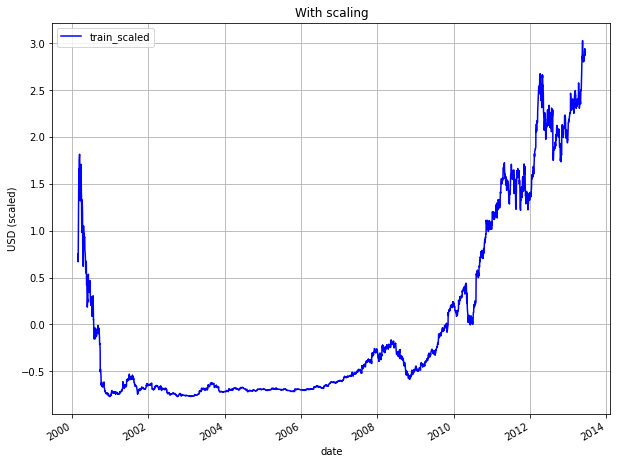

In [ ]:
rcParams['figure.figsize'] = 10, 8 # width 10, height 8

ax = train_scaled.plot(x='date', y='adj_close', style='b-', grid=True)
ax.legend(['train_scaled'])
ax.set_xlabel("date")
ax.set_ylabel("USD (scaled)")
ax.set_title("With scaling")

In [ ]:
model = XGBRegressor(seed=model_seed,
                     n_estimators=n_estimators,
                     max_depth=max_depth,
                     learning_rate=learning_rate,
                     min_child_weight=min_child_weight,
                     subsample=subsample,
                     colsample_bytree=colsample_bytree,
                     colsample_bylevel=colsample_bylevel,
                     gamma=gamma)

# Train the regressor
model.fit(X_train_scaled, y_train_scaled)

[00:08:26] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(seed=100)

In [ ]:
# Do prediction on train set
est_scaled = model.predict(X_train_scaled)
est = est_scaled * math.sqrt(scaler.var_[0]) + scaler.mean_[0]

# Calculate RMSE
print("RMSE on train set = %0.3f" % math.sqrt(mean_squared_error(y_train, est)))

# Calculate MAPE
print("MAPE on train set = %0.3f%%" % get_mape(y_train, est))

RMSE on train set = 5.559
MAPE on train set = 3.077%


Text(0.5, 1.0, 'Without scaling')

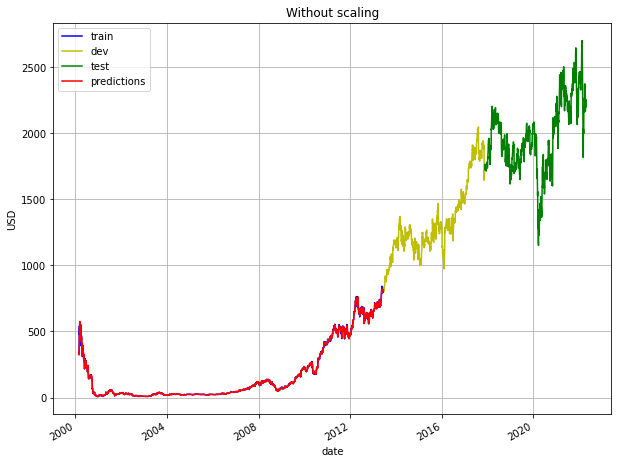

In [ ]:
rcParams['figure.figsize'] = 10, 8 # width 10, height 8

est_df = pd.DataFrame({'est': est, 
                       'date': train['date']})

ax = train.plot(x='date', y='adj_close', style='b-', grid=True)
ax = cv.plot(x='date', y='adj_close', style='y-', grid=True, ax=ax)
ax = test.plot(x='date', y='adj_close', style='g-', grid=True, ax=ax)
ax = est_df.plot(x='date', y='est', style='r-', grid=True, ax=ax)
ax.legend(['train', 'dev', 'test', 'predictions'])
ax.set_xlabel("date")
ax.set_ylabel("USD")
ax.set_title('Without scaling')

In [ ]:
# Do prediction on test set
est_scaled = model.predict(X_cv_scaled)
cv['est_scaled'] = est_scaled
cv['est'] = cv['est_scaled'] * cv['adj_close_std'] + cv['adj_close_mean']

# Calculate RMSE
rmse_bef_tuning = math.sqrt(mean_squared_error(y_cv, cv['est']))
print("RMSE on dev set = %0.3f" % rmse_bef_tuning)

# Calculate MAPE
mape_bef_tuning = get_mape(y_cv, cv['est'])
print("MAPE on dev set = %0.3f%%" % mape_bef_tuning)

RMSE on dev set = 23.001
MAPE on dev set = 1.152%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Text(0, 0.5, 'USD')

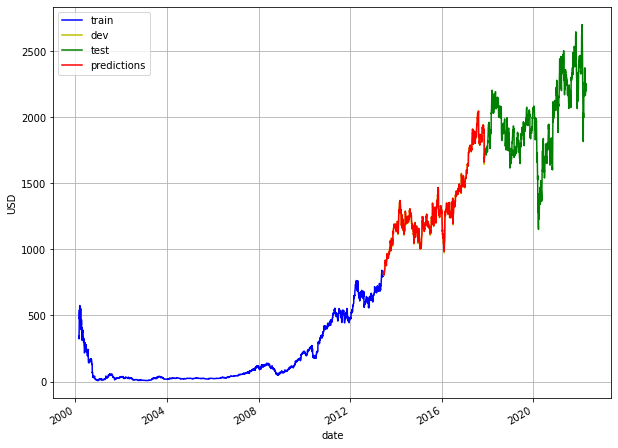

In [ ]:
# Plot adjusted close over time
rcParams['figure.figsize'] = 10, 8 # width 10, height 8

est_df = pd.DataFrame({'est': cv['est'], 
                       'y_cv': y_cv,
                       'date': cv['date']})

ax = train.plot(x='date', y='adj_close', style='b-', grid=True)
ax = cv.plot(x='date', y='adj_close', style='y-', grid=True, ax=ax)
ax = test.plot(x='date', y='adj_close', style='g-', grid=True, ax=ax)
ax = est_df.plot(x='date', y='est', style='r-', grid=True, ax=ax)
ax.legend(['train', 'dev', 'test', 'predictions'])
ax.set_xlabel("date")
ax.set_ylabel("USD")

Text(0.5, 1.0, 'Zoom in to dev set')

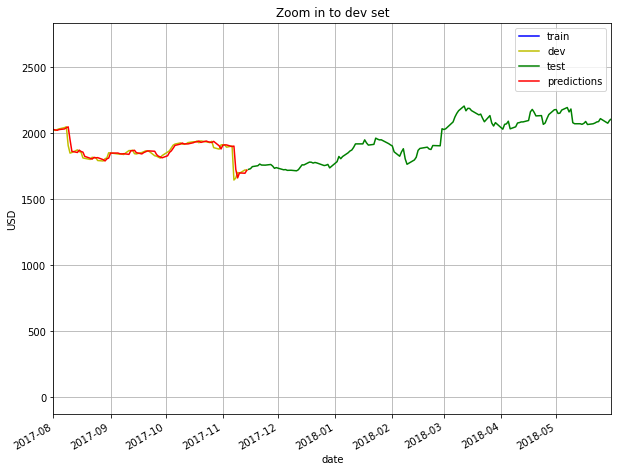

In [ ]:
# Plot adjusted close over time, for dev set only
rcParams['figure.figsize'] = 10, 8 # width 10, height 8
ax = train.plot(x='date', y='adj_close', style='b-', grid=True)
ax = cv.plot(x='date', y='adj_close', style='y-', grid=True, ax=ax)
ax = test.plot(x='date', y='adj_close', style='g-', grid=True, ax=ax)
ax = est_df.plot(x='date', y='est', style='r-', grid=True, ax=ax)
ax.legend(['train', 'dev', 'test', 'predictions'])
ax.set_xlabel("date")
ax.set_ylabel("USD")
ax.set_xlim([date(2017, 8, 1), date(2018, 5, 31)])
ax.set_title("Zoom in to dev set")

In [ ]:
# View a list of the features and their importance scores
imp = list(zip(train[features], model.feature_importances_))
imp.sort(key=lambda tup: tup[1]) 
imp[-10:]

[('range_oc_lag_1', 0.00026311446),
 ('range_oc_lag_3', 0.0002791453),
 ('volume_lag_3', 0.00028216792),
 ('range_hl_lag_2', 0.00028657657),
 ('range_oc_lag_2', 0.00030560378),
 ('volume_lag_1', 0.0004551541),
 ('range_hl_lag_3', 0.0004646307),
 ('adj_close_lag_3', 0.0013275092),
 ('adj_close_lag_2', 0.27156654),
 ('adj_close_lag_1', 0.7242728)]

In [ ]:
d = {'N': [2, 3, 4, 5, 6, 7, 14],
     'rmse_dev_set': [1.225, 1.214, 1.231, 1.249, 1.254, 1.251, 1.498],
     'mape_pct_dev_set': [0.585, 0.581, 0.590, 0.601, 0.609, 0.612, 0.763]}
pd.DataFrame(d)

,N,rmse_dev_set,mape_pct_dev_set
0,2,1.225,0.585
1,3,1.214,0.581
2,4,1.231,0.590
3,5,1.249,0.601
4,6,1.254,0.609
5,7,1.251,0.612
6,14,1.498,0.763


In [ ]:
param_label = 'n_estimators'
param_list = range(10, 310, 10)

param2_label = 'max_depth'
param2_list = [2, 3, 4, 5, 6, 7, 8, 9]

error_rate = {param_label: [] , param2_label: [], 'rmse': [], 'mape_pct': []}
tic = time.time()
for param in tqdm_notebook(param_list):
#     print("param = " + str(param))
    
    for param2 in param2_list:
        # Train, predict and eval model
        rmse, mape, _ = train_pred_eval_model(X_train_scaled, 
                                     y_train_scaled, 
                                     X_cv_scaled, 
                                     y_cv, 
                                     cv['adj_close_mean'],
                                     cv['adj_close_std'],
                                     seed=model_seed,
                                     n_estimators=param, 
                                     max_depth=param2, 
                                     learning_rate=learning_rate, 
                                     min_child_weight=min_child_weight, 
                                     subsample=subsample, 
                                     colsample_bytree=colsample_bytree, 
                                     colsample_bylevel=colsample_bylevel, 
                                     gamma=gamma)
    
        # Collect results
        error_rate[param_label].append(param)
        error_rate[param2_label].append(param2)
        error_rate['rmse'].append(rmse)
        error_rate['mape_pct'].append(mape)
    
error_rate = pd.DataFrame(error_rate)
toc = time.time()
print("Minutes taken = " + str((toc-tic)/60.0))
error_rate   

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  if __name__ == '__main__':


  0%|          | 0/30 [00:00<?, ?it/s]

[00:12:20] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:12:20] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:12:20] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:12:20] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:12:20] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:12:21] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:12:21] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:12:21] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

,n_estimators,max_depth,rmse,mape_pct
0,10,2,24.366047,1.218828
1,10,3,24.700556,1.242382
2,10,4,24.292724,1.222329
3,10,5,24.327208,1.224861
4,10,6,24.328834,1.224128
...,...,...,...,...
235,300,5,22.997227,1.151045
236,300,6,22.974175,1.149929
237,300,7,22.814942,1.141861
238,300,8,22.860872,1.144396


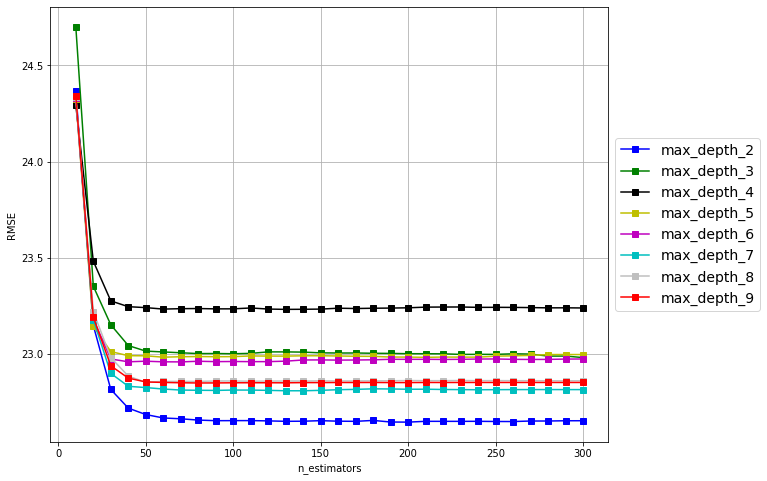

In [ ]:
# Plot performance versus params
rcParams['figure.figsize'] = 10, 8 # width 10, height 8
temp = error_rate[error_rate[param2_label]==param2_list[0]]
ax = temp.plot(x=param_label, y='rmse', style='bs-', grid=True)
legend_list = [param2_label + '_' + str(param2_list[0])]

color_list = ['r', 'g', 'k', 'y', 'm', 'c', '0.75']
for i in range(1,len(param2_list)):
    temp = error_rate[error_rate[param2_label]==param2_list[i]]
    ax = temp.plot(x=param_label, y='rmse', color=color_list[i%len(color_list)], marker='s', grid=True, ax=ax)
    legend_list.append(param2_label + '_' + str(param2_list[i]))

ax.set_xlabel(param_label)
ax.set_ylabel("RMSE")
matplotlib.rcParams.update({'font.size': 14})
plt.legend(legend_list, loc='center left', bbox_to_anchor=(1.0, 0.5)) # positions legend outside figure

In [ ]:
temp = error_rate[error_rate['rmse'] == error_rate['rmse'].min()]
n_estimators_opt = temp['n_estimators'].values[0]
max_depth_opt = temp['max_depth'].values[0]
print("min RMSE = %0.3f" % error_rate['rmse'].min())
print("optimum params = ")
n_estimators_opt, max_depth_opt

min RMSE = 22.646
optimum params = 


(200, 2)

In [ ]:
# Get optimum value for param and param2, using MAPE
temp = error_rate[error_rate['mape_pct'] == error_rate['mape_pct'].min()]
print("min MAPE = %0.3f%%" % error_rate['mape_pct'].min())
print("optimum params = ")
temp['n_estimators'].values[0], temp['max_depth'].values[0]

min MAPE = 1.134%
optimum params = 


(130, 2)

In [ ]:
param_label = 'learning_rate'
param_list = [0.001, 0.005, 0.01, 0.05, 0.1, 0.2, 0.3]

param2_label = 'min_child_weight'
param2_list = range(5, 21, 1)

error_rate = {param_label: [] , param2_label: [], 'rmse': [], 'mape_pct': []}
tic = time.time()
for param in tqdm_notebook(param_list):
#     print("param = " + str(param))
    
    for param2 in param2_list:
        # Train, predict and eval model
        rmse, mape, _ = train_pred_eval_model(X_train_scaled, 
                                     y_train_scaled, 
                                     X_cv_scaled, 
                                     y_cv, 
                                     cv['adj_close_mean'],
                                     cv['adj_close_std'],
                                     seed=model_seed,
                                     n_estimators=n_estimators_opt, 
                                     max_depth=max_depth_opt, 
                                     learning_rate=param, 
                                     min_child_weight=param2, 
                                     subsample=subsample, 
                                     colsample_bytree=colsample_bytree, 
                                     colsample_bylevel=colsample_bylevel, 
                                     gamma=gamma)
    
        # Collect results
        error_rate[param_label].append(param)
        error_rate[param2_label].append(param2)
        error_rate['rmse'].append(rmse)
        error_rate['mape_pct'].append(mape)
    
error_rate = pd.DataFrame(error_rate)
toc = time.time()
print("Minutes taken = " + str((toc-tic)/60.0))
error_rate  

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  if __name__ == '__main__':


  0%|          | 0/7 [00:00<?, ?it/s]

[00:19:46] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:19:47] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:19:48] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:19:48] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:19:49] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:19:49] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:19:50] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:19:50] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

,learning_rate,min_child_weight,rmse,mape_pct
0,0.001,5,28.458488,1.436367
1,0.001,6,28.458488,1.436367
2,0.001,7,28.458488,1.436367
3,0.001,8,28.458488,1.436367
4,0.001,9,28.458488,1.436367
...,...,...,...,...
107,0.300,16,22.694716,1.136254
108,0.300,17,22.706958,1.136937
109,0.300,18,22.679535,1.135641
110,0.300,19,22.698460,1.136927


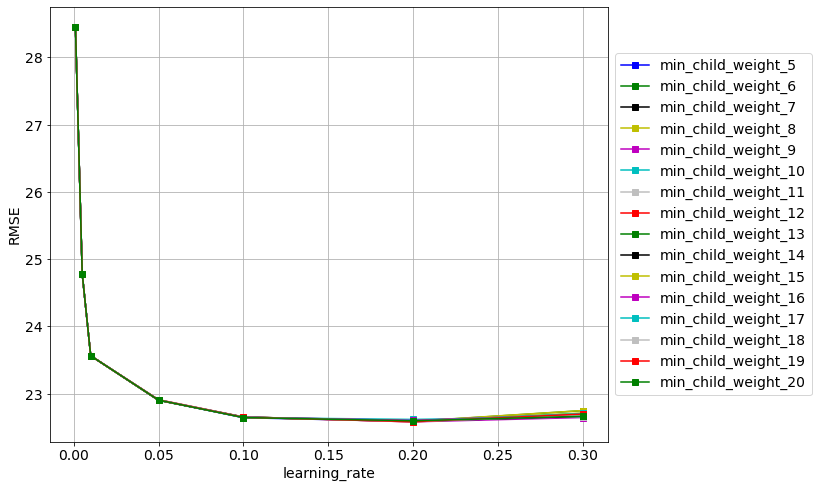

In [ ]:
# Plot performance versus params
rcParams['figure.figsize'] = 10, 8 # width 10, height 8
temp = error_rate[error_rate[param2_label]==param2_list[0]]
ax = temp.plot(x=param_label, y='rmse', style='bs-', grid=True)
legend_list = [param2_label + '_' + str(param2_list[0])]

color_list = ['r', 'g', 'k', 'y', 'm', 'c', '0.75']
for i in range(1,len(param2_list)):
    temp = error_rate[error_rate[param2_label]==param2_list[i]]
    ax = temp.plot(x=param_label, y='rmse', color=color_list[i%len(color_list)], marker='s', grid=True, ax=ax)
    legend_list.append(param2_label + '_' + str(param2_list[i]))

ax.set_xlabel(param_label)
ax.set_ylabel("RMSE")
matplotlib.rcParams.update({'font.size': 14})
plt.legend(legend_list, loc='center left', bbox_to_anchor=(1.0, 0.5)) # positions legend outside figure

In [ ]:
# Get optimum value for param and param2
temp = error_rate[error_rate['rmse'] == error_rate['rmse'].min()]
learning_rate_opt = temp['learning_rate'].values[0]
min_child_weight_opt = temp['min_child_weight'].values[0]
print("min RMSE = %0.3f" % error_rate['rmse'].min())
print("optimum params = ")
learning_rate_opt, min_child_weight_opt

min RMSE = 22.582
optimum params = 


(0.2, 12)

In [ ]:
# Get optimum value for param and param2, using MAPE
# We will use RMSE to decide the final optimum params to use
temp = error_rate[error_rate['mape_pct'] == error_rate['mape_pct'].min()]
print("min MAPE = %0.3f%%" % error_rate['mape_pct'].min())
print("optimum params = ")
temp['learning_rate'].values[0], temp['min_child_weight'].values[0]

min MAPE = 1.130%
optimum params = 


(0.2, 12)

In [ ]:
param_label = 'subsample'
param_list = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]

param2_label = 'gamma'
param2_list = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]

error_rate = {param_label: [] , param2_label: [], 'rmse': [], 'mape_pct': []}
tic = time.time()
for param in tqdm_notebook(param_list):
#     print("param = " + str(param))
    
    for param2 in param2_list:
        # Train, predict and eval model
        rmse, mape, _ = train_pred_eval_model(X_train_scaled, 
                                     y_train_scaled, 
                                     X_cv_scaled, 
                                     y_cv, 
                                     cv['adj_close_mean'],
                                     cv['adj_close_std'],
                                     seed=model_seed,
                                     n_estimators=n_estimators_opt, 
                                     max_depth=max_depth_opt, 
                                     learning_rate=learning_rate_opt, 
                                     min_child_weight=min_child_weight_opt, 
                                     subsample=param, 
                                     colsample_bytree=colsample_bytree, 
                                     colsample_bylevel=colsample_bylevel, 
                                     gamma=param2)
    
        # Collect results
        error_rate[param_label].append(param)
        error_rate[param2_label].append(param2)
        error_rate['rmse'].append(rmse)
        error_rate['mape_pct'].append(mape)
    
error_rate = pd.DataFrame(error_rate)
toc = time.time()
print("Minutes taken = " + str((toc-tic)/60.0))
error_rate

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  if __name__ == '__main__':


  0%|          | 0/10 [00:00<?, ?it/s]

[00:21:50] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:21:50] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:21:51] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:21:51] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:21:52] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:21:52] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:21:52] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:21:53] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

,subsample,gamma,rmse,mape_pct
0,0.1,0.1,24.271734,1.237435
1,0.1,0.2,24.288983,1.237174
2,0.1,0.3,24.370837,1.242219
3,0.1,0.4,24.455333,1.245849
4,0.1,0.5,24.319695,1.238332
...,...,...,...,...
95,1.0,0.6,22.666542,1.134022
96,1.0,0.7,22.667847,1.134050
97,1.0,0.8,22.697554,1.135415
98,1.0,0.9,22.697859,1.135425


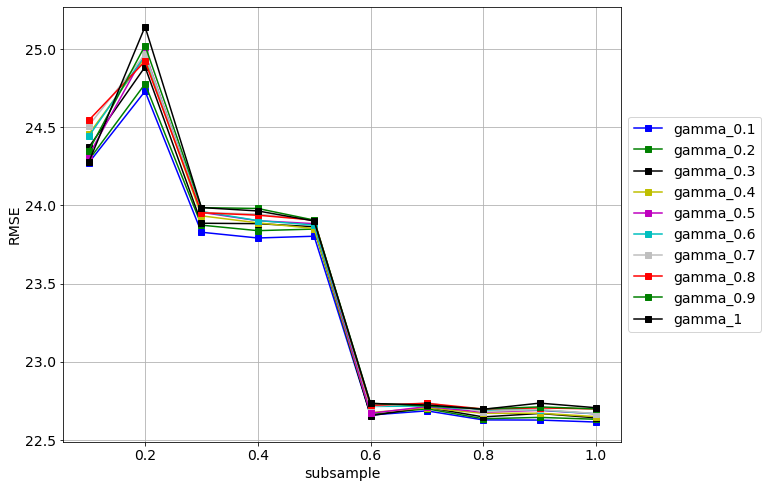

In [ ]:
# Plot performance versus params
rcParams['figure.figsize'] = 10, 8 # width 10, height 8
temp = error_rate[error_rate[param2_label]==param2_list[0]]
ax = temp.plot(x=param_label, y='rmse', style='bs-', grid=True)
legend_list = [param2_label + '_' + str(param2_list[0])]

color_list = ['r', 'g', 'k', 'y', 'm', 'c', '0.75']
for i in range(1,len(param2_list)):
    temp = error_rate[error_rate[param2_label]==param2_list[i]]
    ax = temp.plot(x=param_label, y='rmse', color=color_list[i%len(color_list)], marker='s', grid=True, ax=ax)
    legend_list.append(param2_label + '_' + str(param2_list[i]))

ax.set_xlabel(param_label)
ax.set_ylabel("RMSE")
matplotlib.rcParams.update({'font.size': 14})
plt.legend(legend_list, loc='center left', bbox_to_anchor=(1.0, 0.5)) # positions legend outside figure

In [ ]:
# Get optimum value for param and param2
temp = error_rate[error_rate['rmse'] == error_rate['rmse'].min()]
subsample_opt = temp['subsample'].values[0]
gamma_opt = temp['gamma'].values[0]
print("min RMSE = %0.3f" % error_rate['rmse'].min())
print("optimum params = ")
subsample_opt, gamma_opt

min RMSE = 22.614
optimum params = 


(1.0, 0.1)

In [ ]:
# Get optimum value for param and param2, using MAPE
# We will use RMSE to decide the final optimum params to use
temp = error_rate[error_rate['mape_pct'] == error_rate['mape_pct'].min()]
print("min MAPE = %0.3f%%" % error_rate['mape_pct'].min())
print("optimum params = ")
temp['subsample'].values[0], temp['gamma'].values[0]

min MAPE = 1.132%
optimum params = 


(1.0, 0.1)

In [ ]:
param_label = 'colsample_bytree'
param_list = [0.5, 0.6, 0.7, 0.8, 0.9, 1]

param2_label = 'colsample_bylevel'
param2_list = [0.5, 0.6, 0.7, 0.8, 0.9, 1]

error_rate = {param_label: [] , param2_label: [], 'rmse': [], 'mape_pct': []}
tic = time.time()
for param in tqdm_notebook(param_list):
#     print("param = " + str(param))
    
    for param2 in param2_list:
        # Train, predict and eval model
        rmse, mape, _ = train_pred_eval_model(X_train_scaled, 
                                     y_train_scaled, 
                                     X_cv_scaled, 
                                     y_cv, 
                                     cv['adj_close_mean'],
                                     cv['adj_close_std'],
                                     seed=model_seed,
                                     n_estimators=n_estimators_opt, 
                                     max_depth=max_depth_opt, 
                                     learning_rate=learning_rate_opt, 
                                     min_child_weight=min_child_weight_opt, 
                                     subsample=subsample_opt, 
                                     colsample_bytree=param, 
                                     colsample_bylevel=param2, 
                                     gamma=gamma_opt)
    
        # Collect results
        error_rate[param_label].append(param)
        error_rate[param2_label].append(param2)
        error_rate['rmse'].append(rmse)
        error_rate['mape_pct'].append(mape)
    
error_rate = pd.DataFrame(error_rate)
toc = time.time()
print("Minutes taken = " + str((toc-tic)/60.0))
error_rate  

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  if __name__ == '__main__':


  0%|          | 0/6 [00:00<?, ?it/s]

[00:23:35] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:23:36] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:23:36] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:23:37] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:23:37] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:23:38] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:23:38] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:23:38] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

,colsample_bytree,colsample_bylevel,rmse,mape_pct
0,0.5,0.5,25.997978,1.350605
1,0.5,0.6,25.997978,1.350605
2,0.5,0.7,26.350302,1.386505
3,0.5,0.8,26.350302,1.386505
4,0.5,0.9,23.820494,1.212126
5,0.5,1.0,23.714953,1.200420
6,0.6,0.5,26.767240,1.404105
7,0.6,0.6,25.726030,1.339028
8,0.6,0.7,25.726030,1.339028
9,0.6,0.8,23.606255,1.185988


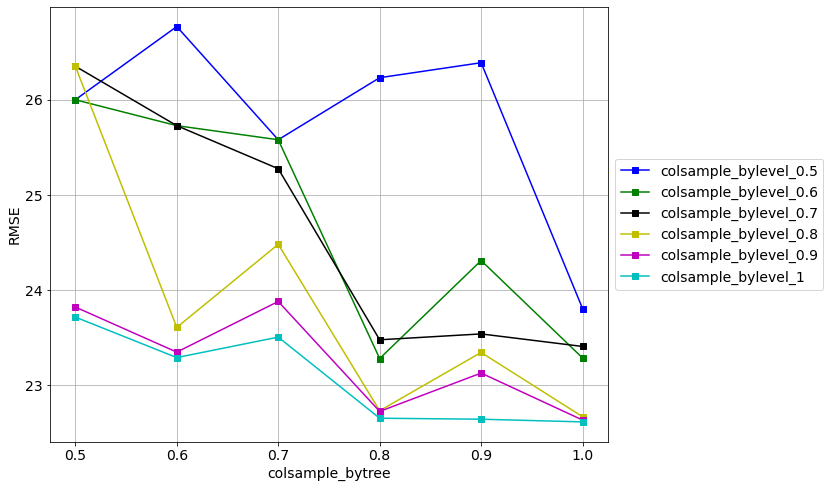

In [ ]:
# Plot performance versus params
rcParams['figure.figsize'] = 10, 8 # width 10, height 8
temp = error_rate[error_rate[param2_label]==param2_list[0]]
ax = temp.plot(x=param_label, y='rmse', style='bs-', grid=True)
legend_list = [param2_label + '_' + str(param2_list[0])]

color_list = ['r', 'g', 'k', 'y', 'm', 'c', '0.75']
for i in range(1,len(param2_list)):
    temp = error_rate[error_rate[param2_label]==param2_list[i]]
    ax = temp.plot(x=param_label, y='rmse', color=color_list[i%len(color_list)], marker='s', grid=True, ax=ax)
    legend_list.append(param2_label + '_' + str(param2_list[i]))

ax.set_xlabel(param_label)
ax.set_ylabel("RMSE")
matplotlib.rcParams.update({'font.size': 14})
plt.legend(legend_list, loc='center left', bbox_to_anchor=(1.0, 0.5)) # positions legend outside figure

In [ ]:
# Get optimum value for param and param2
temp = error_rate[error_rate['rmse'] == error_rate['rmse'].min()]
colsample_bytree_opt = temp['colsample_bytree'].values[0]
colsample_bylevel_opt = temp['colsample_bylevel'].values[0]
print("min RMSE = %0.3f" % error_rate['rmse'].min())
print("optimum params = ")
colsample_bytree_opt, colsample_bylevel_opt

min RMSE = 22.614
optimum params = 


(1.0, 1.0)

In [ ]:
# Get optimum value for param and param2, using MAPE
# We will use RMSE to decide the final optimum params to use
temp = error_rate[error_rate['mape_pct'] == error_rate['mape_pct'].min()]
print("min MAPE = %0.3f%%" % error_rate['mape_pct'].min())
print("optimum params = ")
temp['colsample_bytree'].values[0], temp['colsample_bylevel'].values[0]

min MAPE = 1.132%
optimum params = 


(1.0, 1.0)

In [ ]:
d = {'param': ['n_estimators', 'max_depth', 'learning_rate', 'min_child_weight', 'subsample', 'colsample_bytree', 'colsample_bylevel', 'gamma', 'rmse', 'mape_pct'],
     'original': [n_estimators, max_depth, learning_rate, min_child_weight, subsample, colsample_bytree, colsample_bylevel, gamma, rmse_bef_tuning, mape_bef_tuning],
     'after_tuning': [n_estimators_opt, max_depth_opt, learning_rate_opt, min_child_weight_opt, subsample_opt, colsample_bytree_opt, colsample_bylevel_opt, gamma_opt, error_rate['rmse'].min(), error_rate['mape_pct'].min()]}
tuned_params = pd.DataFrame(d)
tuned_params = tuned_params.round(3)
tuned_params

,param,original,after_tuning
0,n_estimators,100.000,200.000
1,max_depth,3.000,2.000
2,learning_rate,0.100,0.200
3,min_child_weight,1.000,12.000
4,subsample,1.000,1.000
5,colsample_bytree,1.000,1.000
6,colsample_bylevel,1.000,1.000
7,gamma,0.000,0.100
8,rmse,23.001,22.614
9,mape_pct,1.152,1.132


In [ ]:
rmse, mape, est = train_pred_eval_model(X_train_cv_scaled, 
                             y_train_cv_scaled, 
                             X_sample_scaled, 
                             y_sample, 
                             test['adj_close_mean'],
                             test['adj_close_std'],
                             seed=model_seed,
                             n_estimators=n_estimators_opt, 
                             max_depth=max_depth_opt, 
                             learning_rate=learning_rate_opt, 
                             min_child_weight=min_child_weight_opt, 
                             subsample=subsample_opt, 
                             colsample_bytree=colsample_bytree_opt, 
                             colsample_bylevel=colsample_bylevel_opt, 
                             gamma=gamma_opt)

# Calculate RMSE
print("RMSE on test set = %0.3f" % rmse)

# Calculate MAPE
print("MAPE on test set = %0.3f%%" % mape)

[00:24:44] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
RMSE on test set = 42.740
MAPE on test set = 1.524%


Text(0, 0.5, 'USD')

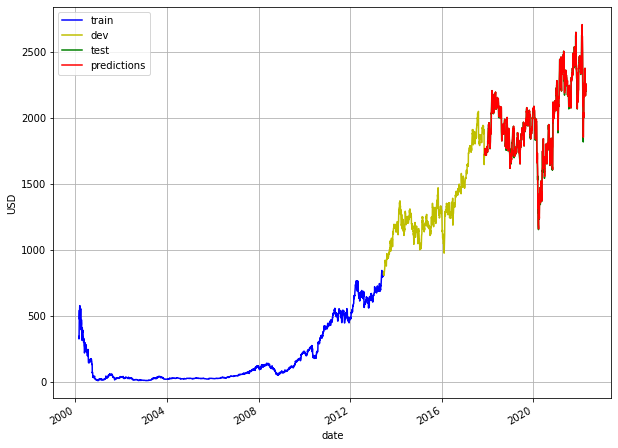

In [ ]:
# Plot adjusted close over time
rcParams['figure.figsize'] = 10, 8 # width 10, height 8

est_df = pd.DataFrame({'est': est, 
                       'y_sample': y_sample,
                       'date': test['date']})

ax = train.plot(x='date', y='adj_close', style='b-', grid=True)
ax = cv.plot(x='date', y='adj_close', style='y-', grid=True, ax=ax)
ax = test.plot(x='date', y='adj_close', style='g-', grid=True, ax=ax)
ax = est_df.plot(x='date', y='est', style='r-', grid=True, ax=ax)
ax.legend(['train', 'dev', 'test', 'predictions'])
ax.set_xlabel("date")
ax.set_ylabel("USD")